In [1]:
import pylidc as pl

# 1. Scan class

In [2]:
# Query for all CT scans with desired traits.
scans = pl.query(pl.Scan).filter(pl.Scan.slice_thickness <= 1,
                                 pl.Scan.pixel_spacing <= 0.6)
print(scans.count())
# => 31

31


In [3]:
pid = 'LIDC-IDRI-0078'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

In [4]:
print(len(scan.annotations))

13


### Annotation clustering 

In [5]:
nods = scan.cluster_annotations()

print("%s has %d nodules." % (scan, len(nods)))
# => Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.

for i,nod in enumerate(nods):
    print("Nodule %d has %d annotations." % (i+1, len(nods[i])))
# => Nodule 1 has 4 annotations.
# => Nodule 2 has 4 annotations.
# => Nodule 3 has 1 annotations.
# => Nodule 4 has 4 annotations.

Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.
Nodule 1 has 4 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 1 annotations.
Nodule 4 has 4 annotations.


### Converting scan image values to NumPy array

##### ~/.pylidcrc
```
[dicom]
path = /lung/data/2_public/LIDC-IDRI-new/volumes/manifest-1600709154662/LIDC-IDRI
warn = True
```

In [6]:
vol = scan.to_volume()
print(vol.shape)
# => (512, 512, 87)

print("%.2f, %.2f" % (vol.mean(), vol.std()))
# => -702.15, 812.52

Loading dicom files ... This may take a moment.
(512, 512, 87)
-702.15, 812.52


### Scan visualization

Loading dicom files ... This may take a moment.


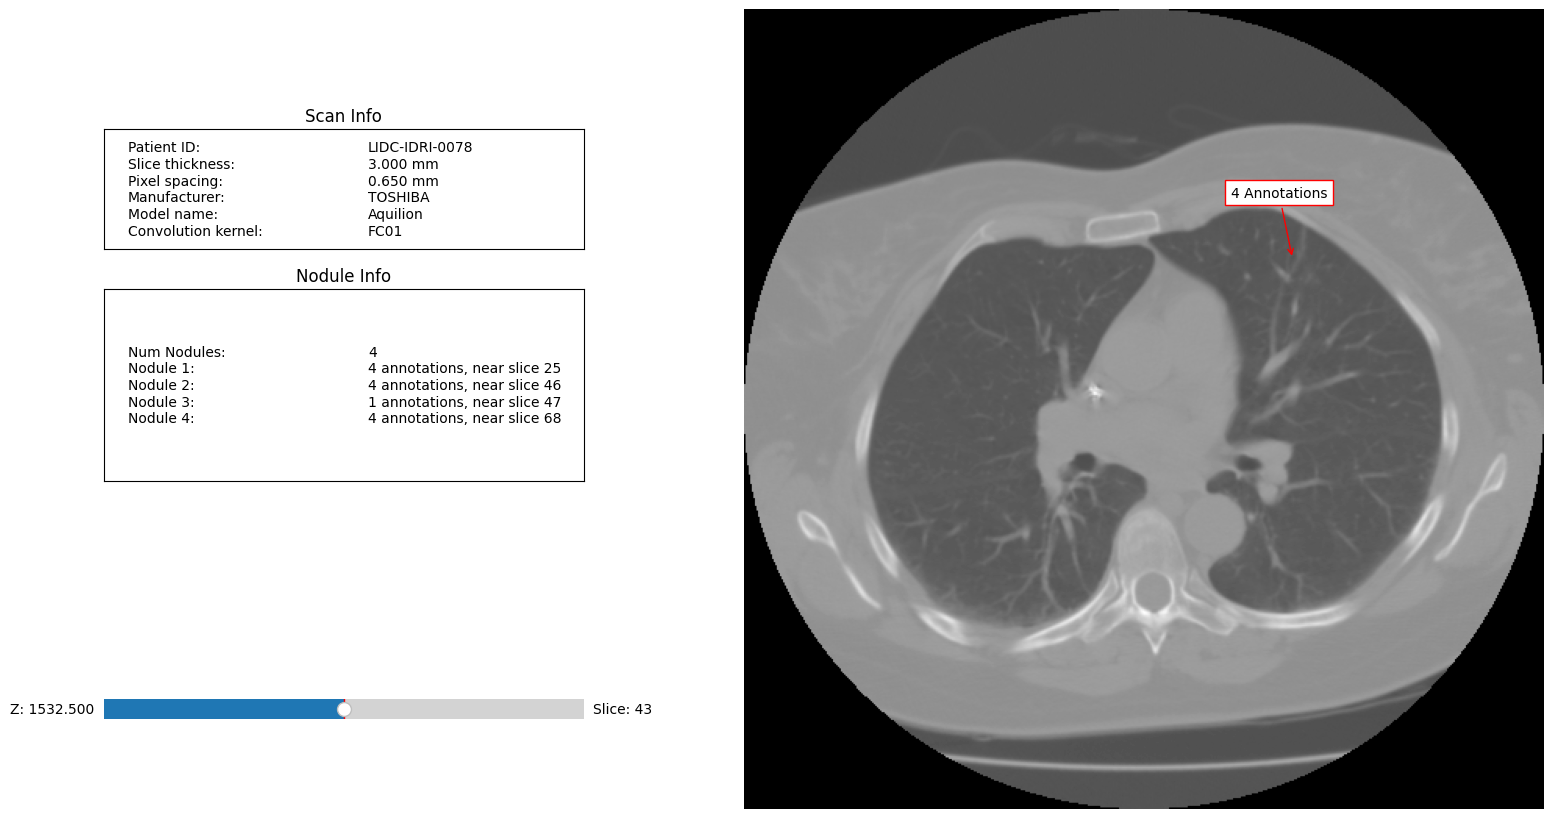

In [7]:
scan.visualize(annotation_groups=nods)

# 2. Annotation class

In [8]:
ann = pl.query(pl.Annotation).first()
print(ann.scan.patient_id)
# => LIDC-IDRI-0078

LIDC-IDRI-0078


### Querying annotation feature values

In [9]:
anns = pl.query(pl.Annotation).filter(pl.Annotation.spiculation == 5,
                                      pl.Annotation.malignancy == 5)
print(anns.count())
# => 91

91


### Not all of the class attributes are queryable! Some attributes are actually computed properties.

In [10]:
print(type(pl.Annotation.lobulation))
# => <class 'sqlalchemy.orm.attributes.InstrumentedAttribute'>
# => ^^^ queryable because it's an sqlalchemy attribute.

# Whereas ...
print(type(pl.Annotation.Lobulation))
# => <type 'property'>
# ^^^ not queryable because it's a computed property

<class 'sqlalchemy.orm.attributes.InstrumentedAttribute'>
<class 'property'>


### A : B
```
A : numerical values
b : a corresponding computed property that gives the semantic interpretation of the numerical value for a given characteristic
```

In [11]:
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.malignancy == 5).first()

print(ann.malignancy, ann.Malignancy)
# => 5, 'Highly Suspicious'

print(ann.margin, ann.Margin)
# => 2, 'Near Poorly Defined'

5 Highly Suspicious
2 Near Poorly Defined


### The names of these characteristics 

In [13]:
pl.annotation_feature_names

('subtlety',
 'internalStructure',
 'calcification',
 'sphericity',
 'margin',
 'lobulation',
 'spiculation',
 'texture',
 'malignancy')

### All of these characteristics values and strings

In [14]:
ann.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 


### query directly for the attributes themselves

In [15]:
svals = pl.query(pl.Annotation.spiculation)\
          .filter(pl.Annotation.spiculation > 3)

print(svals[0])
# => (4,)

print(all([s[0] > 3 for s in svals]))
# => True

(4,)
True


### Contour-derived data¶


In [16]:
ann = pl.query(pl.Annotation).first()
contours = ann.contours

print(contours[0])
# => Contour(id=21,annotation_id=1)

Contour(id=1,annotation_id=1)


##### The diameter, surface_area, and volume attributes are computed properties.

In [18]:
print("%.2f mm, %.2f mm^2, %.2f mm^3" % (ann.diameter,
                                         ann.surface_area,
                                         ann.volume))
# => 20.84 mm, 1242.74 mm^2, 2439.30 mm^3

20.84 mm, 1124.13 mm^2, 2439.30 mm^3


##### A boolean-valued volume can be obtained that is 1 to indicate nodule and 0 to indicate non-nodule:
```
the boolean mask sits within the computed “bounding box” of the nodule
```

In [19]:
mask = ann.boolean_mask()
print(mask.shape, mask.dtype)
# => (34, 27, 6), dtype('bool')

(34, 27, 6) bool


### pylidc.Annotation.bbox() 
- returns a tuple of slices corresponding to the nodule bounding box indices.

In [20]:
bbox = ann.bbox()
print(bbox)
# => (slice(151, 185, None), slice(349, 376, None), slice(44, 50, None))

vol = ann.scan.to_volume()
print(vol[bbox].shape)
# => (34, 27, 6)

(slice(151, 185, None), slice(349, 376, None), slice(44, 50, None))
Loading dicom files ... This may take a moment.
(34, 27, 6)


In [21]:
# get the physical dimensions of the bounding box:
print(ann.bbox_dims())
# => [21.45, 16.90, 15.0]

[21.45 16.9  15.  ]


### Annotation visualization

Loading dicom files ... This may take a moment.


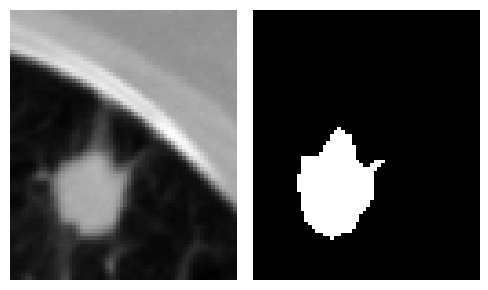

In [22]:
import pylidc as pl
import matplotlib.pyplot as plt

ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()

padding = [(30,10), (10,25), (0,0)]

mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

fig,ax = plt.subplots(1,2,figsize=(5,3))

ax[0].imshow(vol[bbox][:,:,2], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(mask[:,:,2], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

### Surface visualization
- AttributeError: module 'matplotlib.cm' has no attribute 'cmap_d'

In [25]:
# ann = pl.query(pl.Annotation)\
#         .filter(pl.Annotation.lobulation == 5).first()
# ann.visualize_in_3d()

### CT visualization

Loading dicom files ... This may take a moment.


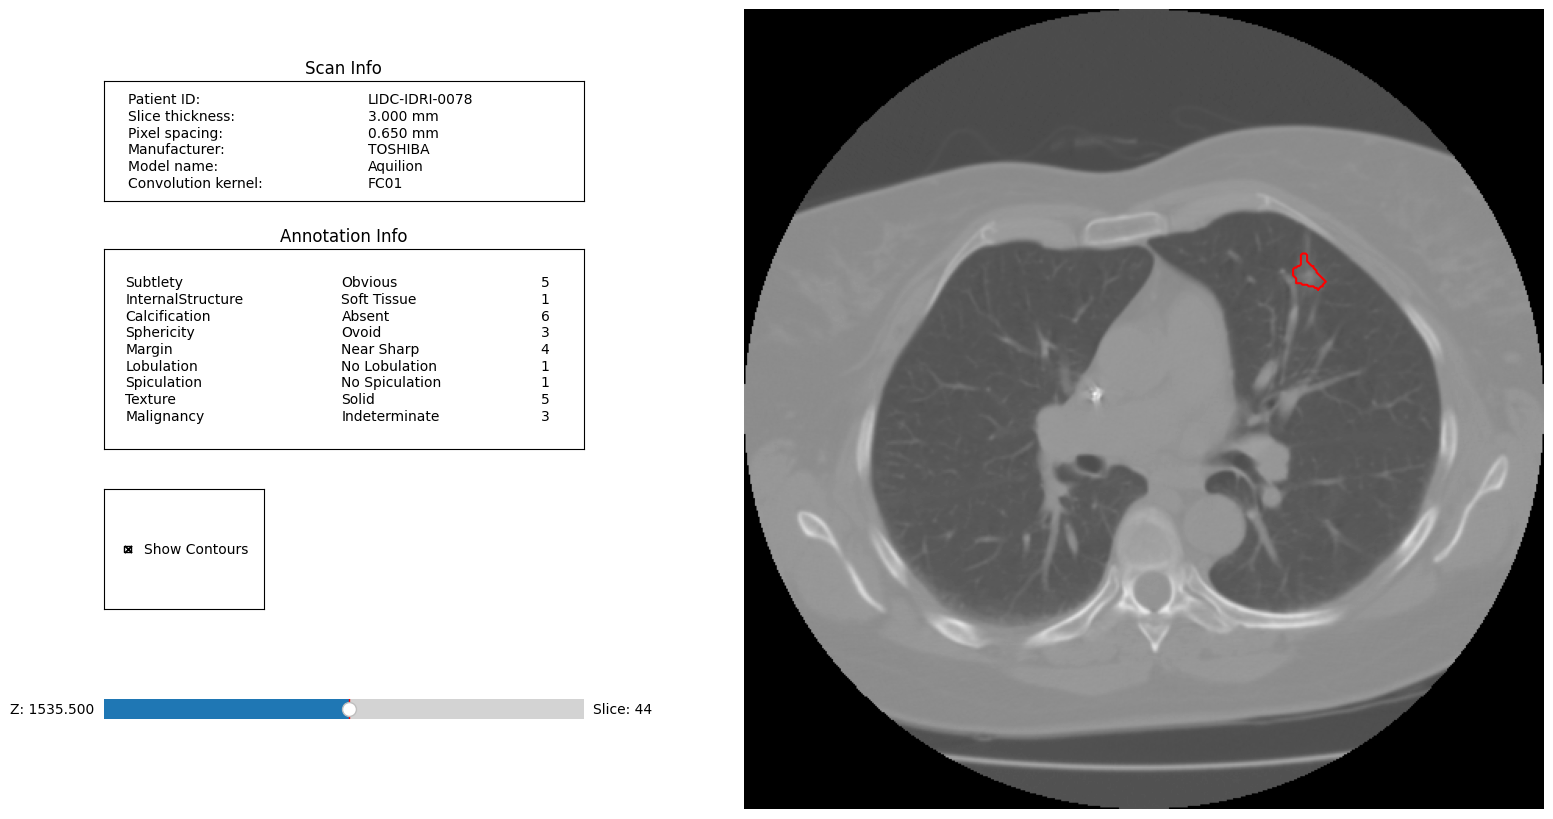

In [26]:
ann = pl.query(pl.Annotation).first()
ann.visualize_in_scan()

# 3. Annotation consensus

Loading dicom files ... This may take a moment.


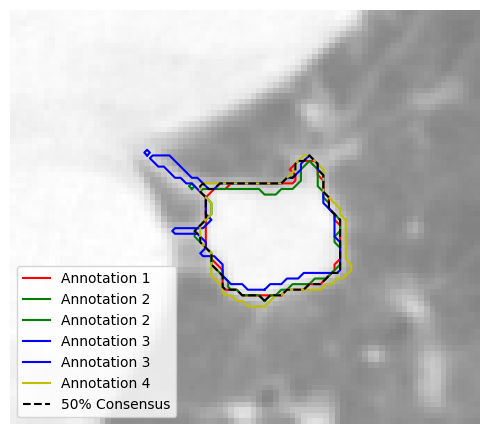

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from skimage.measure import find_contours

import pylidc as pl
from pylidc.utils import consensus


# Query for a scan, and convert it to an array volume.
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0078').first()
vol = scan.to_volume()

# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[0]

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

# Get the central slice of the computed bounding box.
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
#plt.savefig("../images/consensus.png", bbox_inches="tight")
plt.show()
